# Testing How Best To Determine Point Removal

In [11]:
import os
import tsplib95
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import signal
import tqdm
from multiprocess import Pool
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import *
from scipy.stats import ttest_ind
from statistics import mean
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.neighbors import KernelDensity

from wsp import tsp, ds

INCLUDE_LEAVES = False
# FILE_DIR, N = "DATA_GEN_20p0.25", 20
# FILE_DIR, N = "DATA_GEN_30p0.33", 30
FILE_DIR, N = "DATA_GEN_50p0.33", 50
AX = np.array([None, None])
S_FACTOR = 2.0
S_FACTOR_B = 4.0
TREE_TYPE = ds.PKPRQuadTree

In [12]:
top_problems = sorted(os.listdir(FILE_DIR))


len(top_problems)

2

## Problem Injestion

In [16]:
def filter_leaves(decomp):
    return all(not tree.leaf for tree in decomp) if not INCLUDE_LEAVES else True

def count_wspd(wspd):
    return sum(1 for x in wspd if filter_leaves(x[0]))

def mean_sep(pair_sep_dict):
    return mean(special_dist.sep for pair, special_dist in pair_sep_dict.items() if filter_leaves(pair))

def sum_sep(pair_sep_dict):
    return sum(special_dist.sep for pair, special_dist in pair_sep_dict.items() if filter_leaves(pair))

def rel_diff(a,b):
    return float('nan') if a == 0 and b == 0 else (a - b) / (a + b)

In [58]:
base_df = pd.DataFrame(columns=['name', 'parent', 'path_reduction', 'path_discount', 'optimal_percent', 'removal_count', 'wsp_spec_reduction', 'wsp_spec_reduction_B', 'wsp_spec_reduction_sep', 'wsp_spec_reduction_sep_B', 'point_specific_wsp', 'point_specific_wsp_B', 'point_specific_wsp_weighted', 'point_specific_wsp_weighted_B', 'point_specific_sep_share', 'point_specific_sep_share_B', 'point_average_cost', 'point_maximum_cost', 'point_minimum_cost', 'point_average_cost_weighted', 'point_maximum_cost_weighted', 'point_minimum_cost_weighted'])
base_df = base_df.astype({'name': str, 'parent': str, 'path_reduction': float, 'path_discount': float, 'optimal_percent': float, 'removal_count': float, 'wsp_spec_reduction': float, 'wsp_spec_reduction_B': float, 'wsp_spec_reduction_sep_B': float, 'wsp_spec_reduction_sep': float, 'point_specific_wsp': float, 'point_specific_wsp_B': float, 'point_specific_wsp_weighted': float, 'point_specific_wsp_weighted_B': float, 'point_specific_sep_share': float, 'point_specific_sep_share_B': float, 'point_average_cost': float, 'point_maximum_cost': float, 'point_minimum_cost': float, 'point_average_cost_weighted': float, 'point_maximum_cost_weighted': float, 'point_minimum_cost_weighted': float})
base_df.set_index('name', inplace=True)

In [59]:
removed_problems : list[tsplib95.models.StandardProblem] = []
def setup(top_problem):
    main_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{top_problem}.tsp")
    main_conc_cost = float(main_problem.comment.split(' ')[2])
    main_points = [ds.Point(*main_problem.node_coords[i]) for i in main_problem.get_nodes()]

    main_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR)
    main_problem_object_B = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR_B)

    main_cost = main_problem_object.calc_dist(
        [main_points[i-1] for i in main_problem.tours[0]] + [main_points[main_problem.tours[0][0] - 1]]
    )

    updates = base_df.copy()

    best_discount = float('inf')

    total_sep = sum_sep(main_problem_object.pair_sep_dict)
    total_sep_B = sum_sep(main_problem_object_B.pair_sep_dict)
    main_count_wspd = count_wspd(main_problem_object.wspd)
    main_count_wspd_B = count_wspd(main_problem_object_B.wspd)
    main_mean_sep = mean_sep(main_problem_object.pair_sep_dict)
    main_mean_sep_B = mean_sep(main_problem_object_B.pair_sep_dict)
    for removal_name in os.listdir(f"{FILE_DIR}/{top_problem}"): # need to filter in only single point removals here
        if '_' not in removal_name: continue
        removed_point_numbers = [int(s.split('.')[0]) for s in removal_name.split('_')[1:]] # numbers of the missing point in the og
        removed_points = [main_points[i-1] for i in removed_point_numbers]

        sub_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{removal_name}")
        sub_conc_cost = float(sub_problem.comment.split(' ')[2])
        sub_points = [ds.Point(*sub_problem.node_coords[i]) for i in sub_problem.get_nodes()]
        sub_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR)
        sub_problem_object_B = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR_B)
        sub_cost = sub_problem_object.calc_dist(
            [sub_points[i-1] for i in sub_problem.tours[0]] + [sub_points[sub_problem.tours[0][0] - 1]]
        )

        # Strict Inclusion
        point_specific_wsp = sum(
            sum(1 for connectionTree in connections if (not connectionTree.leaf) or INCLUDE_LEAVES)
            for tree, connections in main_problem_object.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and removed_points in tree
        )
        point_specific_wsp_B = sum(
            sum(1 for connectionTree in connections if (not connectionTree.leaf) or INCLUDE_LEAVES)
            for tree, connections in main_problem_object_B.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and removed_points in tree
        )

        point_specific_wsp_sep_share = sum(
            special.sep for pair, special in main_problem_object.pair_sep_dict.items()
            if any(removed_points in tree for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair))
        ) / total_sep

        point_specific_wsp_sep_share_B = sum(
            special.sep for pair, special in main_problem_object_B.pair_sep_dict.items()
            if any(removed_points in tree for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair))
        ) / total_sep_B
        
        # Any inclusion
        point_specific_wsp = sum(
            sum(1 for connectionTree in connections if (not connectionTree.leaf) or INCLUDE_LEAVES)
            for tree, connections in main_problem_object.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and any(point in tree for point in removed_points)
        )
        point_specific_wsp_B = sum(
            sum(1 for connectionTree in connections if (not connectionTree.leaf) or INCLUDE_LEAVES)
            for tree, connections in main_problem_object_B.single_indexable_wspd.items()
            if (INCLUDE_LEAVES or not tree.leaf) and any(point in tree for point in removed_points)
        )

        point_specific_wsp_sep_share = sum(
            special.sep for pair, special in main_problem_object.pair_sep_dict.items()
            if any(any(point in tree for point in removed_points) for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair))
        ) / total_sep

        point_specific_wsp_sep_share_B = sum(
            special.sep for pair, special in main_problem_object_B.pair_sep_dict.items()
            if any(any(point in tree for point in removed_points) for tree in pair) and (INCLUDE_LEAVES or all(not tree.leaf for tree in pair))
        ) / total_sep_B

        point_edge_costs = main_problem_object.dist_matrix_with_nan[[i - 1 for i in removed_point_numbers]]
        
        best_discount = min(best_discount, (sub_conc_cost / main_conc_cost))

        updates.loc[sub_problem.name] = {
            'parent': top_problem,
            'path_reduction': sub_conc_cost / main_conc_cost,
            'path_discount': 1.0 - (sub_conc_cost / main_conc_cost),
            'removal_count': len(removed_point_numbers),
            'wsp_spec_reduction': rel_diff(main_count_wspd, count_wspd(sub_problem_object.wspd)),
            'wsp_spec_reduction_B': rel_diff(main_count_wspd_B, count_wspd(sub_problem_object_B.wspd)),
            'wsp_spec_reduction_sep': rel_diff(main_mean_sep, mean_sep(sub_problem_object.pair_sep_dict)),
            'wsp_spec_reduction_sep_B': rel_diff(main_mean_sep_B, mean_sep(sub_problem_object_B.pair_sep_dict)),
            'point_specific_wsp': point_specific_wsp,
            'point_specific_wsp_B': point_specific_wsp_B,
            'point_specific_wsp_weighted': point_specific_wsp / main_count_wspd,
            'point_specific_wsp_weighted_B': point_specific_wsp_B / main_count_wspd_B,
            'point_specific_sep_share': point_specific_wsp_sep_share,
            'point_specific_sep_share_B': point_specific_wsp_sep_share_B,
            'point_average_cost': np.nanmean(point_edge_costs),
            'point_maximum_cost': np.nanmax(point_edge_costs),
            'point_minimum_cost': np.nanmin(point_edge_costs),
            'point_average_cost_weighted': np.nanmean(point_edge_costs) / main_cost,
            'point_maximum_cost_weighted': np.nanmax(point_edge_costs) / main_cost,
            'point_minimum_cost_weighted': np.nanmin(point_edge_costs) / main_cost,
        }
    updates['optimal_percent'] = updates['path_discount'] / best_discount
    return updates

original_sigint_handler = signal.signal(signal.SIGINT, signal.SIG_IGN)
pool = Pool(7) # NUMBER OF PROCESSES
signal.signal(signal.SIGINT, original_sigint_handler)

update_collection = []
u=0
try:
    with tqdm.tqdm(total=len(top_problems), unit="top problem") as pbar:
        for result in pool.imap_unordered(setup, top_problems):
            update_collection.append(result)
            pbar.update(1)
            prob_name = next(iter(result))
            u += 1
            # if result[prob_name] != {}:
            #     u += 1
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name, "last_updated": prob_name, "updated": u}})
            # else:
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name}})
except KeyboardInterrupt:
    print("Caught KeyboardInterrupt, terminating workers")
    pool.terminate()
else:
    pool.close()
pool.join()

print("Injesting updates")
reduction_df = pd.concat(update_collection)
reduction_df

100%|██████████| 2/2 [00:18<00:00,  9.10s/top problem]

Injesting updates


,parent,path_reduction,path_discount,optimal_percent,removal_count,wsp_spec_reduction,wsp_spec_reduction_B,wsp_spec_reduction_sep,wsp_spec_reduction_sep_B,point_specific_wsp,...,point_specific_wsp_weighted,point_specific_wsp_weighted_B,point_specific_sep_share,point_specific_sep_share_B,point_average_cost,point_maximum_cost,point_minimum_cost,point_average_cost_weighted,point_maximum_cost_weighted,point_minimum_cost_weighted
name,,,,,,,,,,,,,,,,,,,,,
aaa50p0.33_38_41,aaa50p0.33,0.981223,0.018777,0.024143,2,0.066667,0.076923,0.005336,0.000063,10,...,0.312500,0.333333,0.307206,0.294434,3218.310853,10914.357701,1.011504,0.043821,0.148612,0.000014
aaa50p0.33_36_50,aaa50p0.33,0.927997,0.072003,0.092580,2,-0.072464,-0.023256,0.024785,0.036679,4,...,0.125000,0.095238,0.136663,0.096450,6190.545303,17617.019372,739.672972,0.084292,0.239877,0.010072
aaa50p0.33_22_25,aaa50p0.33,0.974864,0.025136,0.032319,2,0.163636,0.272727,0.038244,0.069518,13,...,0.406250,0.523810,0.412303,0.535961,4595.011102,12403.061147,522.433015,0.062567,0.168882,0.007114
aaa50p0.33_22_31,aaa50p0.33,0.994690,0.005310,0.006828,2,0.142857,0.235294,0.058377,0.057879,13,...,0.406250,0.571429,0.442346,0.573061,4005.790565,12403.061147,22.403651,0.054544,0.168882,0.000305
aaa50p0.33_36_44,aaa50p0.33,0.987922,0.012078,0.015529,2,0.049180,0.050000,0.018052,0.001168,7,...,0.218750,0.190476,0.212971,0.180945,2881.016288,10271.590877,218.883161,0.039228,0.139860,0.002980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aab50p0.33_5_17,aab50p0.33,0.982466,0.017534,0.021243,2,-0.022727,0.000000,0.002671,-0.003847,11,...,0.255814,0.176471,0.178177,0.134248,3336.675922,12038.929220,0.201757,0.049791,0.179651,0.000003
aab50p0.33_13_16,aab50p0.33,0.995120,0.004880,0.005912,2,0.061728,0.152542,0.050829,0.035980,17,...,0.395349,0.352941,0.385383,0.346144,3562.314709,11425.773745,257.151039,0.053159,0.170501,0.003837
aab50p0.33_14_23,aab50p0.33,0.977974,0.022026,0.026685,2,0.023810,0.000000,-0.015964,-0.014073,8,...,0.186047,0.147059,0.169836,0.146645,3882.725331,13388.976134,189.982028,0.057940,0.199797,0.002835


In [101]:
reduction_df = reduction_df[reduction_df['removal_count'] == 2]

In [102]:
ge0_reduc_df = reduction_df[reduction_df['point_specific_wsp'] > 0]
reduction_df['wsp_spec_reduction'].describe(), reduction_df['wsp_spec_reduction'].isna().sum()
# reduction_df = reduction_df[reduction_df['wsp_spec_reduction'].notna()]

(count    2450.000000
 mean        0.063545
 std         0.082118
 min        -0.123288
 25%         0.000000
 50%         0.048780
 75%         0.103448
 max         0.488372
 Name: wsp_spec_reduction, dtype: float64,
 np.int64(0))

## WSP Reduction Calculations
How much does the difference in global well seperated pairs actually predict anything

In [103]:
reduction_df = reduction_df[reduction_df['wsp_spec_reduction_B'].notna()]
reduction_df = reduction_df[reduction_df['wsp_spec_reduction'].notna()]

In [104]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["wsp_spec_reduction"])).fit()
print(results.summary())

results_B = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[["wsp_spec_reduction", "wsp_spec_reduction_B"]])).fit()
results_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     124.7
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           2.76e-28
Time:                        10:35:10   Log-Likelihood:                 5276.9
No. Observations:                2450   AIC:                        -1.055e+04
Df Residuals:                    2448   BIC:                        -1.054e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9843      0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     63.34
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           1.51e-27
Time:                        10:35:10   Log-Likelihood:                 5277.8
No. Observations:                2450   AIC:                        -1.055e+04
Df Residuals:                    2447   BIC:                        -1.053e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.9845      0.001   1335.290      0.000       0.983       0.986
wsp_spec_reduction      -0.0637      0.012     -5.298      0.000      -0.087      -0.040
wsp_spec_reduction_B    -0.0128      0.009     -1.374      0.169      -0.031       0.005
==============================================================================
Omnibus:                     1155.315   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5494.912
Skew:                          -2.297   Prob(JB):                         0.00
Kurtosis:                       8.720   Cond. No.                         25.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
results2 = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2)", data=reduction_df).fit()
print(results2.summary())

results2_B = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2) + wsp_spec_reduction_B + I(wsp_spec_reduction_B**2)", data=reduction_df).fit()
results2_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     81.87
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           3.85e-35
Time:                        10:35:10   Log-Likelihood:                 5295.3
No. Observations:                2450   AIC:                        -1.058e+04
Df Residuals:                    2447   BIC:                        -1.057e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     41.36
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           1.36e-33
Time:                        10:35:10   Log-Likelihood:                 5296.2
No. Observations:                2450   AIC:                        -1.058e+04
Df Residuals:                    2445   BIC:                        -1.055e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.9833      0.001   1235.297      0.000       0.982       0.985
wsp_spec_reduction               0.0169      0.020      0.851      0.395      -0.022       0.056
I(wsp_spec_reduction ** 2)      -0.3753      0.075     -4.990      0.000      -0.523      -0.228
wsp_spec_reduction_B            -0.0218      0.017     -1.313      0.189      -0.054       0.011
I(wsp_spec_reduction_B ** 2)     0.0482      0.046      1.041      0.298      -0.043       0.139
==============================================================================
Omnibus:                     1195.891   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6132.003
Skew:                          -2.359   Prob(JB):                         0.00
Kurtosis:                       9.149   Cond. No.                         152.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1037681458.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1037681458.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


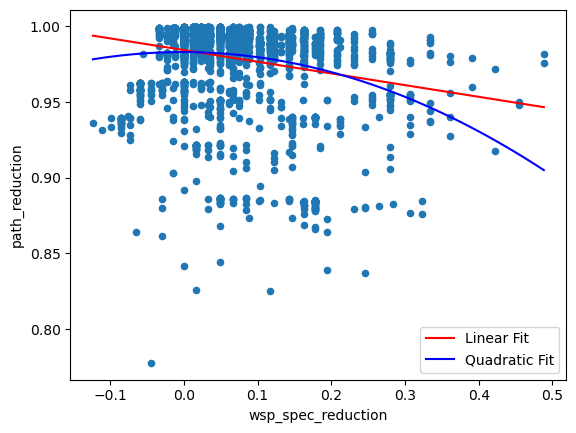

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1037681458.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.9842970661086272)

In [106]:
reduction_df.plot.scatter("wsp_spec_reduction", "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df["wsp_spec_reduction"].min(), reduction_df["wsp_spec_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [107]:
reduction_df["wsp_spec_reduction"].values

array([ 0.06666667, -0.07246377,  0.16363636, ...,  0.0617284 ,
        0.02380952,  0.0617284 ], shape=(2450,))

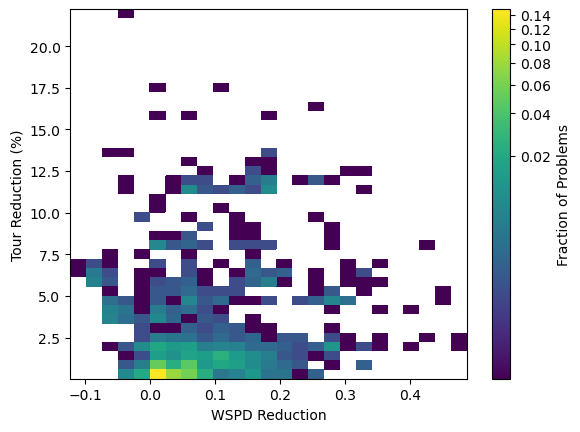

In [108]:
# dummy plot for no output

plt.style.use('default')  # Use the default (light) matplotlib style

h = plt.hist2d(
    reduction_df["wsp_spec_reduction"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.25),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["wsp_spec_reduction"])
norm = PowerNorm(0.25)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('WSPD Reduction')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

### Discount class predictions

In [109]:
COMPARISON_SIZE = 5
path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(COMPARISON_SIZE, 'path_reduction'))
path_largest = reduction_df.groupby("parent").apply(lambda df: df.nlargest(N-COMPARISON_SIZE, 'path_reduction'))

clf_df = pd.concat([
    path_smallest.assign(target=1),
    path_largest.assign(target=0)
])

# Create y to match clf_df
y = clf_df['target']

# Ensure problems with the same parent are either all in train or all in test
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
groups = clf_df['parent']
train_idx, test_idx = next(gss.split(clf_df, y, groups=groups))

X_train, X_test = clf_df.iloc[train_idx].reset_index(drop=True, level='parent'), clf_df.iloc[test_idx].reset_index(drop=True, level='parent')
y_train, y_test = y.iloc[train_idx].reset_index(drop=True, level='parent'), y.iloc[test_idx].reset_index(drop=True, level='parent')

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1218025974.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(COMPARISON_SIZE, 'path_reduction'))
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1218025974.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_largest = reduction_df.groupby("pare

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1986339396.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1986339396.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations we

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.251
Method:                 Least Squares   F-statistic:                   0.09699
Date:                Sun, 29 Jun 2025   Prob (F-statistic):              0.909
Time:                        10:35:10   Log-Likelihood:                 23.130
No. Observations:                  10   AIC:                            -40.26
Df Residuals:                       7   BIC:                            -39.35
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.8350      0.012     71.734      0.000       0.807       0.863
wsp_spec_reduction             0.0042      0.218      0.019      0.985      -0.510       0.519
I(wsp_spec_reduction ** 2)     0.1742      1.133      0.154      0.882      -2.505       2.853
==============================================================================
Omnibus:                        5.489   Durbin-Watson:                   0.955
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                1.961
Skew:                          -1.021   Prob(JB):                        0.375
Kurtosis:                       3.731   Cond. No.                         127.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

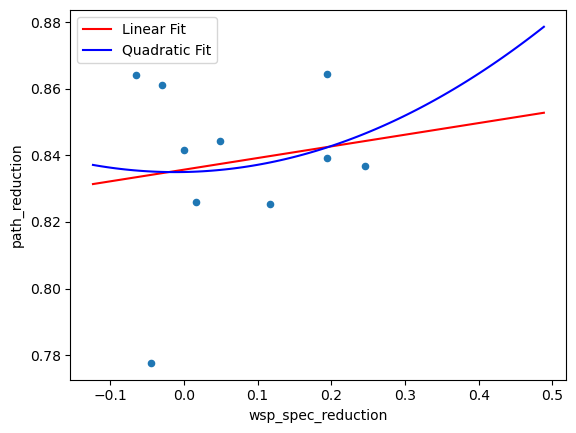

In [110]:
path_smallest.plot.scatter("wsp_spec_reduction", "path_reduction")
results = sm.OLS(path_smallest["path_reduction"], sm.add_constant(path_smallest["wsp_spec_reduction"])).fit()

x = np.linspace(reduction_df["wsp_spec_reduction"].min(), reduction_df["wsp_spec_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

results2 = smf.ols(formula="path_reduction ~ wsp_spec_reduction + I(wsp_spec_reduction**2)", data=path_smallest).fit()
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')
plt.legend()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     10.67
Date:                Sun, 29 Jun 2025   Prob (F-statistic):            0.00155
Time:                        10:35:10   Log-Likelihood:                 724.63
No. Observations:                  90   AIC:                            -1445.
Df Residuals:                      88   BIC:                            -1440.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9996   1.05e-05   9.51e+04      0.000       1.000       1.000
wsp_spec_reduction    -0.0012      0.000     -3.267      0.002      -0.002      -0.000
==============================================================================
Omnibus:                       12.051   Durbin-Watson:                   0.268
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.925
Skew:                          -0.956   Prob(JB):                     0.000947
Kurtosis:                       2.765   Cond. No.                         45.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

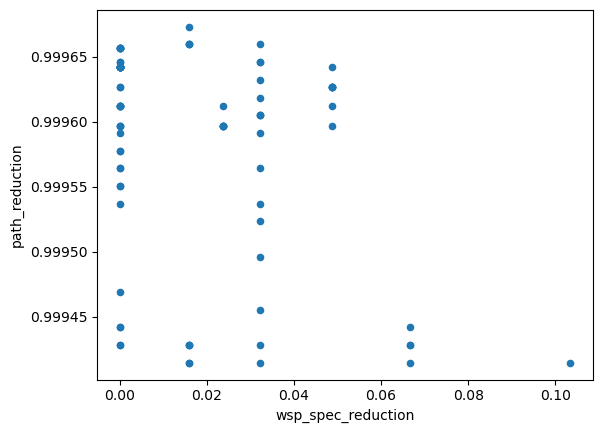

In [111]:
path_largest.plot.scatter("wsp_spec_reduction", "path_reduction")
results = sm.OLS(path_largest["path_reduction"], sm.add_constant(path_largest["wsp_spec_reduction"])).fit()
results.summary()

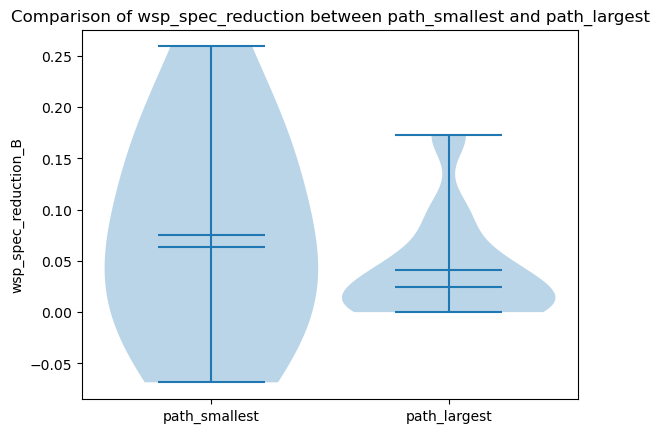

T-statistic: 1.0195, p-value: 0.3333
No statistically significant difference between means (p >= 0.05).


In [112]:
# Create a DataFrame for violin plot comparison
violin_data = [
    path_smallest['wsp_spec_reduction_B'],
    path_largest['wsp_spec_reduction_B']
]

plt.violinplot(violin_data, showmedians=True, showmeans=True, showextrema=True, points=100, widths=0.9)
plt.xticks([1, 2], ['path_smallest', 'path_largest'])
plt.ylabel('wsp_spec_reduction_B')
plt.title('Comparison of wsp_spec_reduction between path_smallest and path_largest')
plt.show()

# Perform independent t-test
stat, p_value = ttest_ind(
    path_smallest['wsp_spec_reduction_B'],
    path_largest['wsp_spec_reduction_B'],
    nan_policy='omit',
    equal_var=False  # Use Welch's t-test if variances are unequal
)

print(f"T-statistic: {stat:.4f}, p-value: {p_value:.4g}")
if p_value < 0.05:
    print("The means are statistically significantly different (p < 0.05).")
else:
    print("No statistically significant difference between means (p >= 0.05).")

In [113]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['wsp_spec_reduction', 'wsp_spec_reduction_B', 'wsp_spec_reduction_sep', 'wsp_spec_reduction_sep_B']].values, X_test[['wsp_spec_reduction', 'wsp_spec_reduction_B', 'wsp_spec_reduction_sep', 'wsp_spec_reduction_sep_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[-4178.78325031  3025.52153932 -1517.44533235  1381.84499052]] [-80.2886229]
              precision    recall  f1-score   support

           0       0.91      0.69      0.78        45
           1       0.12      0.40      0.19         5

    accuracy                           0.66        50
   macro avg       0.52      0.54      0.49        50
weighted avg       0.83      0.66      0.73        50

ROC AUC: 0.30666666666666664


We are able to do a fair job of predicting whether the number of wsps the problem is reduced by has a predictive effect on the shortness of the problem. 

In [114]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth=0.005)
kde_0 = KernelDensity(kernel='exponential', bandwidth=0.005)

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        45
           1       1.00      0.20      0.33         5

    accuracy                           0.92        50
   macro avg       0.96      0.60      0.65        50
weighted avg       0.93      0.92      0.90        50

ROC AUC: 0.6133333333333333


## How much does the wsps on a specific point actually matter

In [115]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp"])).fit()
print(results.summary())

results_B = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[["point_specific_wsp", "point_specific_wsp_B"]])).fit()
results_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     111.6
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           1.56e-25
Time:                        10:35:10   Log-Likelihood:                 5270.6
No. Observations:                2450   AIC:                        -1.054e+04
Df Residuals:                    2448   BIC:                        -1.053e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.9647      0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     162.6
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           4.98e-67
Time:                        10:35:10   Log-Likelihood:                 5368.8
No. Observations:                2450   AIC:                        -1.073e+04
Df Residuals:                    2447   BIC:                        -1.071e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.9689      0.001    658.501      0.000       0.966       0.972
point_specific_wsp      -0.0012      0.000     -5.054      0.000      -0.002      -0.001
point_specific_wsp_B     0.0034      0.000     14.295      0.000       0.003       0.004
==============================================================================
Omnibus:                     1083.812   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4836.356
Skew:                          -2.154   Prob(JB):                         0.00
Kurtosis:                       8.368   Cond. No.                         35.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [116]:
results2 = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2)", data=reduction_df).fit()
print(results2.summary())

results2_B = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2) + point_specific_wsp_B + I(point_specific_wsp_B**2)", data=reduction_df).fit()
results2_B.summary()

                            OLS Regression Results                            
Dep. Variable:         path_reduction   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     57.78
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           3.03e-25
Time:                        10:35:10   Log-Likelihood:                 5272.5
No. Observations:                2450   AIC:                        -1.054e+04
Df Residuals:                    2447   BIC:                        -1.052e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     108.2
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           5.77e-85
Time:                        10:35:10   Log-Likelihood:                 5415.6
No. Observations:                2450   AIC:                        -1.082e+04
Df Residuals:                    2445   BIC:                        -1.079e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.9617      0.003    329.198      0.000       0.956       0.967
point_specific_wsp              -0.0026      0.001     -3.452      0.001      -0.004      -0.001
I(point_specific_wsp ** 2)    5.844e-05   3.53e-05      1.657      0.098   -1.07e-05       0.000
point_specific_wsp_B             0.0083      0.001     13.904      0.000       0.007       0.009
I(point_specific_wsp_B ** 2)    -0.0003   3.43e-05     -8.639      0.000      -0.000      -0.000
==============================================================================
Omnibus:                     1044.347   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4507.967
Skew:                          -2.076   Prob(JB):                         0.00
Kurtosis:                       8.189   Cond. No.                         912.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/830609850.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/830609850.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


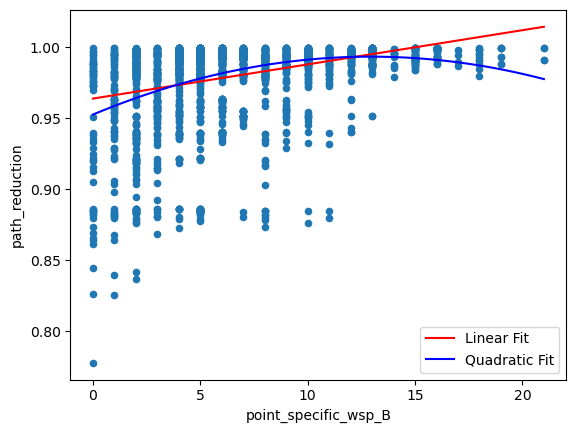

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/830609850.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.9637585770762753)

In [117]:
reduction_df.plot.scatter("point_specific_wsp_B", "path_reduction")
# Plot the first fitted model
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp_B"])).fit()
x = np.linspace(reduction_df["point_specific_wsp_B"].min(), reduction_df["point_specific_wsp_B"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
results2 = smf.ols(formula="path_reduction ~ point_specific_wsp_B + I(point_specific_wsp_B**2)", data=reduction_df).fit()
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

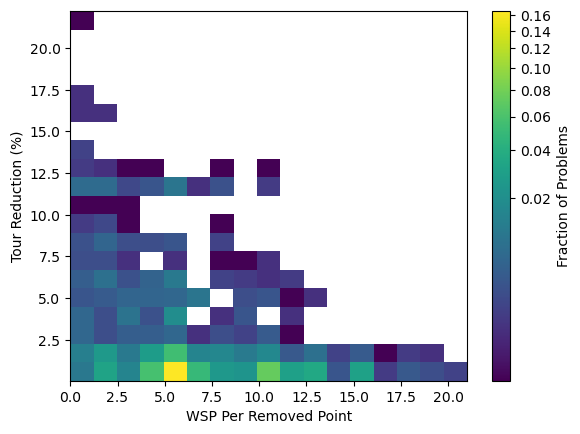

In [118]:
# dummy plot for no output

plt.style.use('default')  # Use the default (light) matplotlib style

h = plt.hist2d(
    reduction_df["point_specific_wsp_B"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.33),
    bins=(17,20),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["point_specific_wsp_B"])
norm = PowerNorm(0.33)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('WSP Per Removed Point')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

In [119]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['point_specific_wsp', 'point_specific_wsp_B']].values, X_test[['point_specific_wsp', 'point_specific_wsp_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[ 2.76950753 -9.97124188]] [9.17427457]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00         5

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

ROC AUC: 1.0


In [120]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth=0.005)
kde_0 = KernelDensity(kernel='exponential', bandwidth=0.005)

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00         5

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

ROC AUC: 1.0


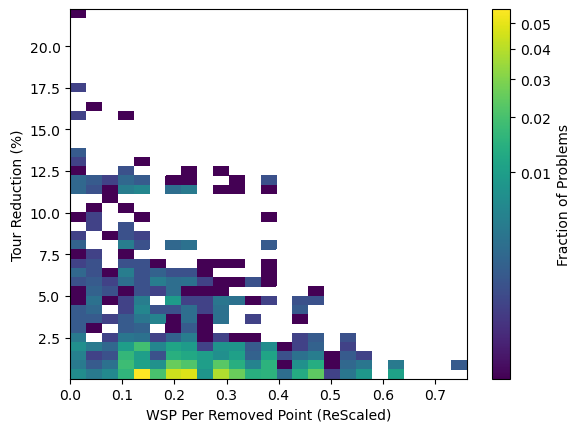

In [121]:
plt.style.use('default')  # Use the default (light) matplotlib style

h = plt.hist2d(
    reduction_df["point_specific_wsp_weighted_B"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.33),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["point_specific_wsp_weighted_B"])
norm = PowerNorm(0.33)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('WSP Per Removed Point (ReScaled)')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

In [122]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['point_specific_wsp_weighted', 'point_specific_wsp_weighted_B']].values, X_test[['point_specific_wsp_weighted', 'point_specific_wsp_weighted_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[  29.87587308 -144.83921846]] [12.09037152]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00         5

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

ROC AUC: 1.0


In [123]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth='silverman')
kde_0 = KernelDensity(kernel='exponential', bandwidth='silverman')

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        45
           1       0.00      0.00      0.00         5

    accuracy                           0.90        50
   macro avg       0.45      0.50      0.47        50
weighted avg       0.81      0.90      0.85        50

ROC AUC: 1.0


/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

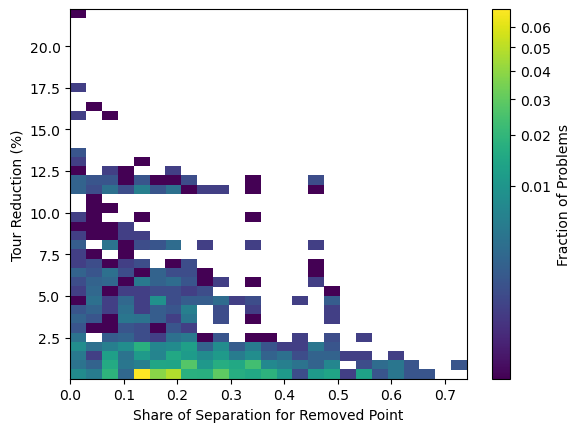

In [124]:
h = plt.hist2d(
    reduction_df["point_specific_sep_share_B"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.33),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["point_specific_sep_share_B"])
norm = PowerNorm(0.33)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('Share of Separation for Removed Point')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

In [125]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['point_specific_sep_share', 'point_specific_sep_share_B']].values, X_test[['point_specific_sep_share', 'point_specific_sep_share_B']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[  46.24579738 -182.33874514]] [12.90079147]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00         5

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

ROC AUC: 1.0


In [126]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth='scott')
kde_0 = KernelDensity(kernel='exponential', bandwidth='scott')

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        45
           1       0.00      0.00      0.00         5

    accuracy                           0.90        50
   macro avg       0.45      0.50      0.47        50
weighted avg       0.81      0.90      0.85        50

ROC AUC: 1.0


/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/addisonhanrattie/Documents/tsp_wsp_hardness.nosync/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

### Considering all metrics

In [127]:
# Subscript the training data
metrics = ['point_specific_wsp_weighted', 'point_specific_wsp_weighted_B', 'point_specific_wsp', 'point_specific_wsp_B', 'point_specific_sep_share', 'point_specific_sep_share_B',
           'wsp_spec_reduction', 'wsp_spec_reduction_B', 'wsp_spec_reduction_sep', 'wsp_spec_reduction_sep_B']
X_train_reduc, X_test_reduc = X_train[metrics].values, X_test[metrics].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[ 0.08251653 -0.44106374  2.64052909 -9.26233855 -0.06677258 -0.50091081
  -0.17740549  0.08484754  0.44668525  0.25038662]] [8.38548263]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00         5

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

ROC AUC: 1.0


In [128]:
# Fit KDE for each class
kde_1 = KernelDensity(kernel='exponential', bandwidth=0.02)
kde_0 = KernelDensity(kernel='exponential', bandwidth=0.02)

# Use the same features as before
X_train_1 = X_train_reduc[y_train == 1]
X_train_0 = X_train_reduc[y_train == 0]

kde_1.fit(X_train_1)
kde_0.fit(X_train_0)

# Compute log density scores for test set
log_dens_1 = kde_1.score_samples(X_test_reduc)
log_dens_0 = kde_0.score_samples(X_test_reduc)

# Predict class by comparing log densities
y_kde_pred = (log_dens_1 > log_dens_0).astype(int)


print(classification_report(y_test, y_kde_pred))
print("ROC AUC:", roc_auc_score(y_test, log_dens_1 - log_dens_0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00         5

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

ROC AUC: 1.0


/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/609549793.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Z = 1 - (results2_B.params[0] + results2_B.params[1] * X + results2_B.params[2] * X**2 + results2_B.params[3] * Y + results2_B.params[4] * Y**2)


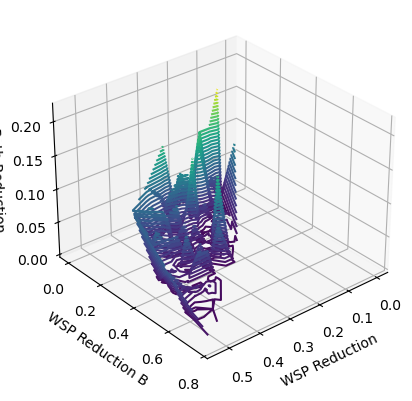

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
x = np.linspace(reduction_df["point_specific_wsp_weighted"].min(), reduction_df["point_specific_wsp_weighted"].max(), 100)
y = np.linspace(reduction_df["point_specific_wsp_weighted_B"].min(), reduction_df["point_specific_wsp_weighted_B"].max(), 100)
X, Y = np.meshgrid(x, y)
Z = 1 - (results2_B.params[0] + results2_B.params[1] * X + results2_B.params[2] * X**2 + results2_B.params[3] * Y + results2_B.params[4] * Y**2)
# ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
# Plot the scatter points
# ax.scatter(reduction_df["point_specific_wsp_weighted"], reduction_df["point_specific_wsp_weighted_B"], 1 - reduction_df["path_reduction"], color='r', alpha=0.1)
ax.tricontour(reduction_df["point_specific_wsp_weighted"], reduction_df["point_specific_wsp_weighted_B"], 1 - reduction_df["path_reduction"], 40, cmap='viridis')
ax.set_xlabel('WSP Reduction')
ax.set_ylabel('WSP Reduction B')
ax.set_zlabel('Path Reduction')

ax.view_init(azim=50, elev=30)

plt.show()

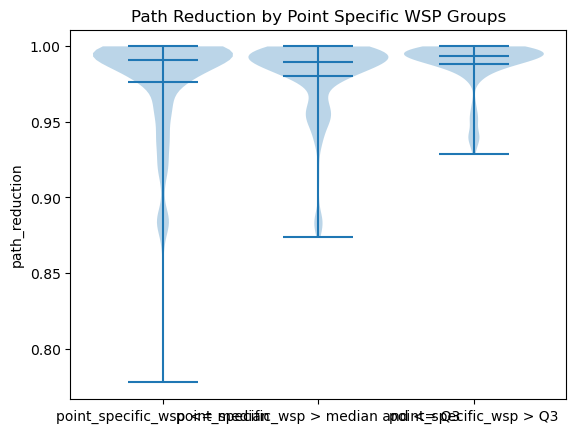

In [130]:
median = reduction_df['point_specific_wsp'].median()
q1 = reduction_df['point_specific_wsp'].quantile(0.25)
q3 = reduction_df['point_specific_wsp'].quantile(0.75)

data = [
    reduction_df[reduction_df['point_specific_wsp'] <= median]['path_reduction'],
    reduction_df[(reduction_df['point_specific_wsp'] > median) & (reduction_df['point_specific_wsp'] <= q3)]['path_reduction'],
    reduction_df[reduction_df['point_specific_wsp'] > q3]['path_reduction']
]

plt.violinplot(data, widths=0.9, points=100, showmeans=True, showmedians=True, showextrema=True)
plt.xticks([1, 2, 3], ['point_specific_wsp <= median', 'point_specific_wsp > median and <= Q3', 'point_specific_wsp > Q3'])
plt.ylabel('path_reduction')
plt.title('Path Reduction by Point Specific WSP Groups')
plt.show()

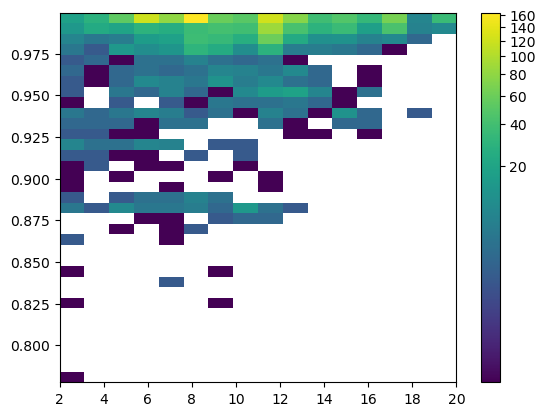

In [131]:
h = plt.hist2d(ge0_reduc_df["point_specific_wsp"], ge0_reduc_df["path_reduction"], bins=(16,35), cmin=1, norm=PowerNorm(0.25))
plt.colorbar(h[3])

## How well do other geometric tools work for this

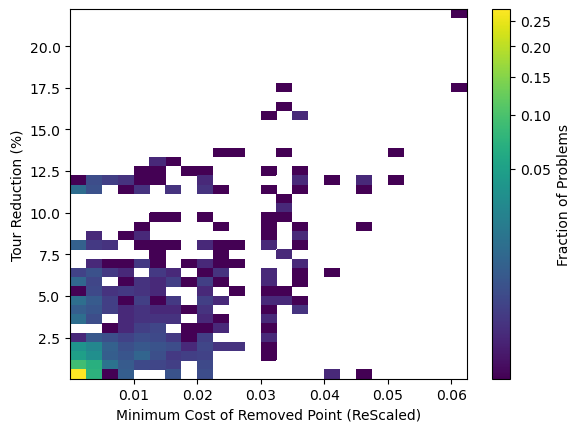

In [132]:
h = plt.hist2d(
    reduction_df["point_minimum_cost_weighted"],
    100 * reduction_df["path_discount"],
    norm=PowerNorm(0.33),
    bins=(25,40),
    density=False,
    cmin=1,
)

h_norm = h[0] / len(reduction_df["point_minimum_cost_weighted"])
norm = PowerNorm(0.33)
im = plt.imshow(
    h_norm.T,
    origin='lower',
    extent=[h[1][0], h[1][-1], h[2][0], h[2][-1]],
    aspect='auto',
    norm=norm,
)
plt.colorbar(im, label='Fraction of Problems')
plt.xlabel('Minimum Cost of Removed Point (ReScaled)')
plt.ylabel('Tour Reduction (%)')

plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

In [133]:
# Subscript the training data
X_train_reduc, X_test_reduc = X_train[['point_minimum_cost_weighted']].values, X_test[['point_minimum_cost_weighted']].values

# Build the model
clf = LogisticRegression(penalty=None, class_weight="balanced")
clf.fit(X_train_reduc, y_train.values)
print(clf.coef_, clf.intercept_)

# Predict and evaluate
y_pred = clf.predict(X_test_reduc)
y_prob = clf.predict_proba(X_test_reduc)[:, 1]

print(classification_report(y_test.values, y_pred))
print("ROC AUC:", roc_auc_score(y_test.values, y_prob))

[[388.76544069]] [-6.80491852]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00         5

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

ROC AUC: 1.0


In [134]:
variable = "point_specific_wsp_weighted"

results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df[variable])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     96.30
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           2.53e-22
Time:                        10:35:11   Log-Likelihood:                 5263.2
No. Observations:                2450   AIC:                        -1.052e+04
Df Residuals:                    2448   BIC:                        -1.051e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.9644      0.002    592.947      0.000       0.961       0.968
point_specific_wsp_weighted     0.0571      0.006      9.813      0.000       0.046       0.069
==============================================================================
Omnibus:                     1077.057   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4563.470
Skew:                          -2.166   Prob(JB):                         0.00
Kurtosis:                       8.094   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
results2 = smf.ols(formula=f"path_reduction ~ {variable} + I({variable}**2)", data=reduction_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     51.37
Date:                Sun, 29 Jun 2025   Prob (F-statistic):           1.40e-22
Time:                        10:35:11   Log-Likelihood:                 5266.4
No. Observations:                2450   AIC:                        -1.053e+04
Df Residuals:                    2447   BIC:                        -1.051e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.9571      0.003    283.895      0.000       0.950       0.964
point_specific_wsp_weighted             0.1208      0.026      4.615      0.000       0.069       0.172
I(point_specific_wsp_weighted ** 2)    -0.1191      0.048     -2.496      0.013      -0.213      -0.026
==============================================================================
Omnibus:                     1073.735   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4521.389
Skew:                          -2.161   Prob(JB):                         0.00
Kurtosis:                       8.061   Cond. No.                         98.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1114625799.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1114625799.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


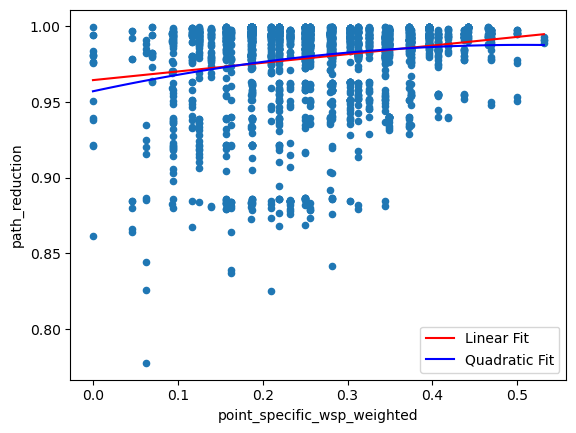

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_72442/1114625799.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


np.float64(0.9644442223764215)

In [136]:
reduction_df.plot.scatter(variable, "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df[variable].min(), reduction_df[variable].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [137]:
results2 = smf.ols(formula=f"optimal_percent ~ point_specific_wsp_weighted + I(point_specific_wsp_weighted**2) + point_average_cost_weighted + I(point_average_cost_weighted**2) + point_maximum_cost_weighted + point_maximum_cost_weighted + I(point_maximum_cost_weighted**2) + point_minimum_cost_weighted", data=reduction_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        optimal_percent   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     434.3
Date:                Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                        10:35:11   Log-Likelihood:                 5649.0
No. Observations:                2450   AIC:                        -1.128e+04
Df Residuals:                    2442   BIC:                        -1.124e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.1279      0.015      8.686      0.000       0.099       0.157
point_specific_wsp_weighted            -0.0403      0.023     -1.734      0.083      -0.086       0.005
I(point_specific_wsp_weighted ** 2)     0.0041      0.042      0.097      0.923      -0.079       0.087
point_average_cost_weighted            -0.4229      0.279     -1.518      0.129      -0.969       0.123
I(point_average_cost_weighted ** 2)     7.5258      1.612      4.667      0.000       4.364      10.688
point_maximum_cost_weighted            -1.3387      0.212     -6.316      0.000      -1.754      -0.923
I(point_maximum_cost_weighted ** 2)     4.1799      0.502      8.331      0.000       3.196       5.164
point_minimum_cost_weighted             0.1584      0.111      1.422      0.155      -0.060       0.377
==============================================================================
Omnibus:                      497.162   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1628.323
Skew:                           1.006   Prob(JB):                         0.00
Kurtosis:                       6.450   Cond. No.                     3.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [138]:
pca = sm.PCA(reduction_df[["point_specific_wsp_weighted", "point_average_cost_weighted", "point_maximum_cost_weighted", "point_minimum_cost_weighted"]][:5000].T)

pca.factors

,comp_0,comp_1,comp_2,comp_3
point_specific_wsp_weighted,-0.643461,-0.579210,-0.021751,-1.043838
point_average_cost_weighted,0.330528,0.094279,-0.794898,0.633814
point_maximum_cost_weighted,-0.305997,0.761141,0.277544,-0.377840
point_minimum_cost_weighted,0.618930,-0.276210,0.539104,0.914685


<Axes: xlabel='point_specific_wsp_weighted', ylabel='point_maximum_cost_weighted'>

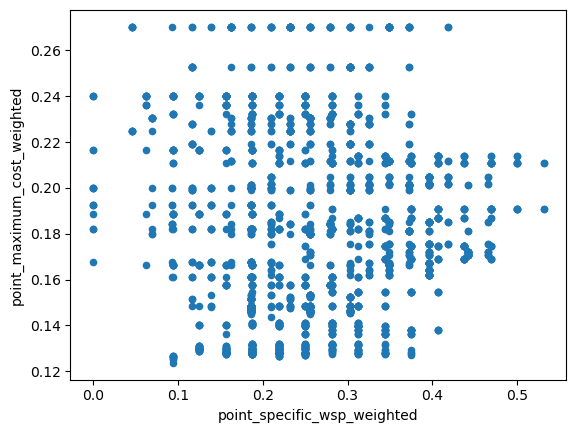

In [139]:
reduction_df.plot.scatter("point_specific_wsp_weighted", "point_maximum_cost_weighted")